In [1]:
#!pip install tensorflow==2.14.0 tensorflow-gpu

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [1]:
!git clone https://github.com/ealeongomez/Time-Series-Forecasting-Using-the-Bayesian-Approach-and-Random-Fourier-Features.git

Cloning into 'Time-Series-Forecasting-Using-the-Bayesian-Approach-and-Random-Fourier-Features'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 55 (delta 10), reused 52 (delta 7), pack-reused 0 (from 0)
Receiving objects: 100% (55/55), 5.11 MiB | 13.22 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [2]:
cd /content/Time-Series-Forecasting-Using-the-Bayesian-Approach-and-Random-Fourier-Features/Experiments-Wind/

/content/Time-Series-Forecasting-Using-the-Bayesian-Approach-and-Random-Fourier-Features/Experiments-Wind


In [3]:
ls -l

total 12
-rw-r--r-- 1 root root 1710 Nov  4 16:11 processing.py
-rw-r--r-- 1 root root 5043 Nov  4 16:11 RandomFourierFeatures.py


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, r2_score

from processing import create_features, split_data
from RandomFourierFeatures import Conv1dRFF

In [5]:
import warnings
warnings.filterwarnings('ignore')

#**Parameters**

In [6]:
window_size = 5
output_dim  = 10000
epochs      = 100
kernel_size = 1

#**Dataset-1 (April Dataset)**

In [8]:
df = pd.read_csv('/content/Time-Series-Forecasting-Using-the-Bayesian-Approach-and-Random-Fourier-Features/Data/DS1_1440.csv')

In [9]:
df

,date,wind_speed
0,2015-04-01 00:00:00,7.07905
1,2015-04-01 00:30:00,7.03170
2,2015-04-01 01:00:00,7.07125
3,2015-04-01 01:30:00,7.42920
4,2015-04-01 02:00:00,6.88420
...,...,...
1435,2015-04-30 21:30:00,9.73170
1436,2015-04-30 22:00:00,10.40910
1437,2015-04-30 22:30:00,10.38510
1438,2015-04-30 23:00:00,9.30260


In [10]:
train_len = int(.6*df.shape[0])
train_data, val_data, test_data = split_data(df.wind_speed.values, train_len)
train_data = np.float32(train_data)
val_data = np.float32(val_data)
test_data = np.float32(test_data)

train_data.shape, val_data.shape, test_data.shape

((864,), (288,), (288,))

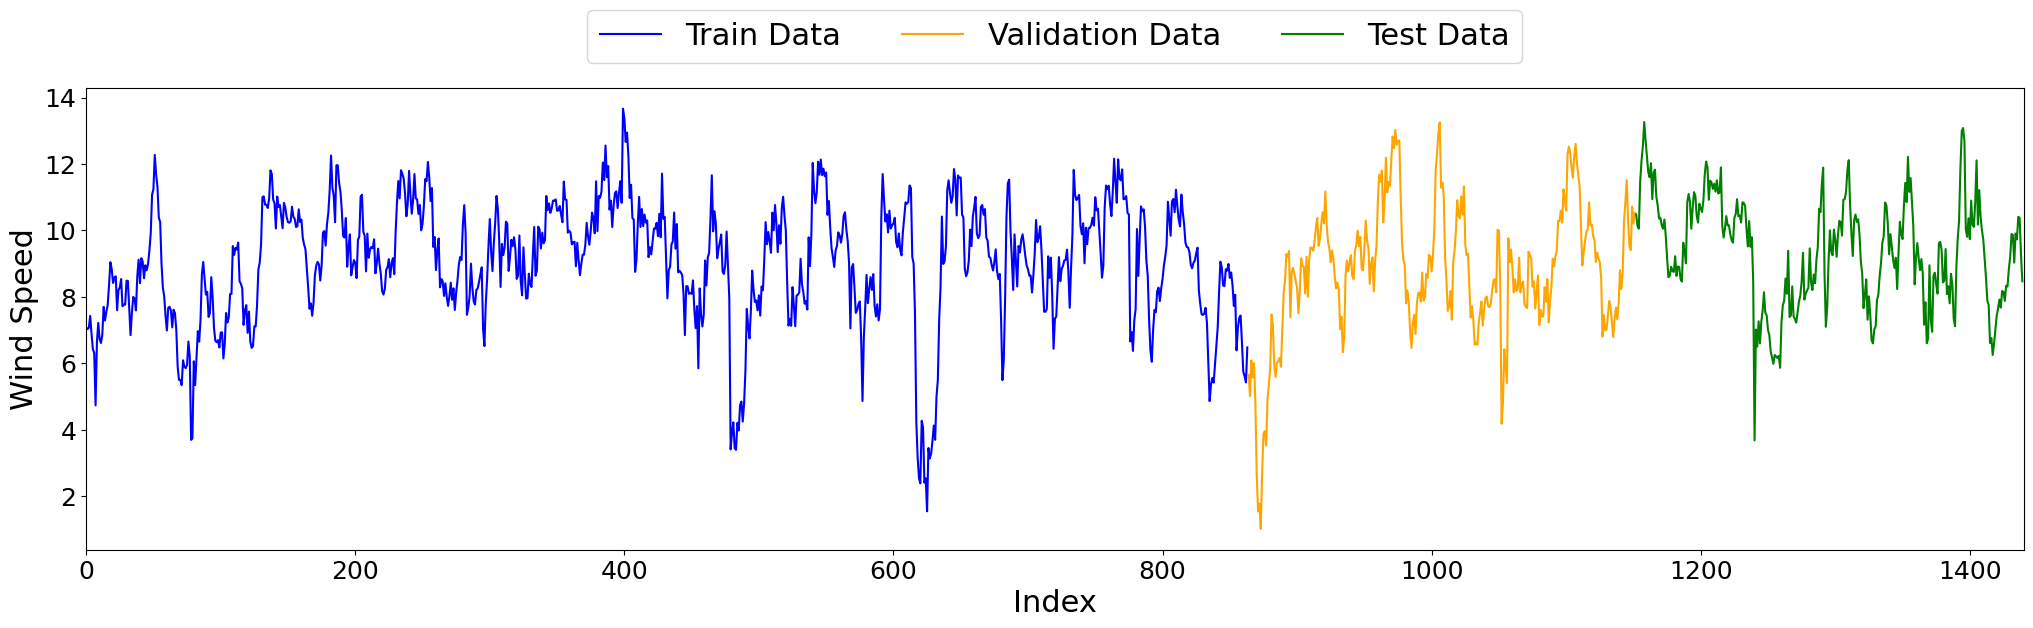

In [24]:
plt.figure(figsize=(25, 6))
plt.plot(train_data, color='blue', label='Train Data')
plt.plot(range(len(train_data), len(train_data) + len(val_data)), val_data, color='orange', label='Validation Data')
plt.plot(range(len(train_data) + len(val_data), len(train_data) + len(val_data) + len(test_data)), test_data, color='green', label='Test Data')

plt.xlabel("Index", size=22)
plt.ylabel("Wind Speed", size=22)
plt.xlim(0, len(train_data) + len(val_data) + len(test_data))

# Ajustar el tamaño de los valores de los ejes x e y
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Leyenda en la parte superior, centrada y en 3 columnas
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.02), ncol=3, prop={'size': 22})

plt.show()


In [12]:
X_train, y_train = create_features(train_data, window_size)
X_valid, y_valid = create_features(val_data, window_size)
X_test, y_test   = create_features(test_data, window_size)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((859, 5), (859,), (283, 5), (283,), (283, 5), (283,))

#**Forecasting**

In [13]:
input = tf.keras.layers.Input(shape=(X_train.shape[1],1), name='Input')

tmp = Conv1dRFF(output_dim, kernel_size=kernel_size, trainable_W=True, trainable_scale=True)(input)
tmp = tf.keras.layers.Flatten()(tmp)
tmp = tf.keras.layers.Dense(units=32, activation='relu',name='Dense_1')(tmp)
output = tf.keras.layers.Dense(units=1, activation='relu')(tmp)

model = tf.keras.Model(inputs=input, outputs=output)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 5, 1)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_rff (Conv1dRFF)               │ (None, 5, 10000)            │          20,001 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 50000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_1 (Dense)                      │ (None, 32)                  │       1,600,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,620,066 (6.18 MB)

 Trainable params: 1,620,066 (6.18 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
history = model.fit(X_train, y_train, epochs=epochs, batch_size=256, validation_data=(X_valid, y_valid))

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 567ms/step - loss: 77.1943 - mae: 8.5800 - mse: 77.1943 - val_loss: 49.6895 - val_mae: 6.7309 - val_mse: 49.6895
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 42.8776 - mae: 6.2418 - mse: 42.8776 - val_loss: 27.9998 - val_mae: 4.5781 - val_mse: 27.9998
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 17.8569 - mae: 3.5530 - mse: 17.8569 - val_loss: 17.0582 - val_mae: 2.9266 - val_mse: 17.0582
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 9.2451 - mae: 2.3013 - mse: 9.2451 - val_loss: 13.9882 - val_mae: 2.7534 - val_mse: 13.9882
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 8.9759 - mae: 2.5230 - mse: 8.9759 - val_loss: 12.2757 - val_mae: 2.7121 - val_mse: 12.2757
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 7.6464 - mae: 2.3446 - mse: 7.6464 - val_loss: 9.4943 - val_mae: 2.2392 - val_mse: 9.4943
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.9656 - mae: 1.7154 - mse: 4.9656 - 

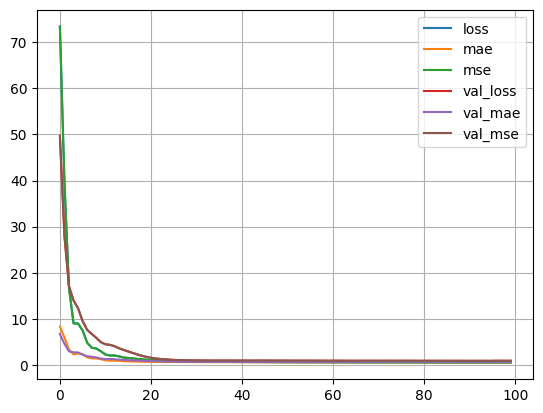

In [15]:
hpd = pd.DataFrame(history.history)
hpd.plot()
plt.grid(True)
plt.show()

In [16]:
forecasting = model.predict(X_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step


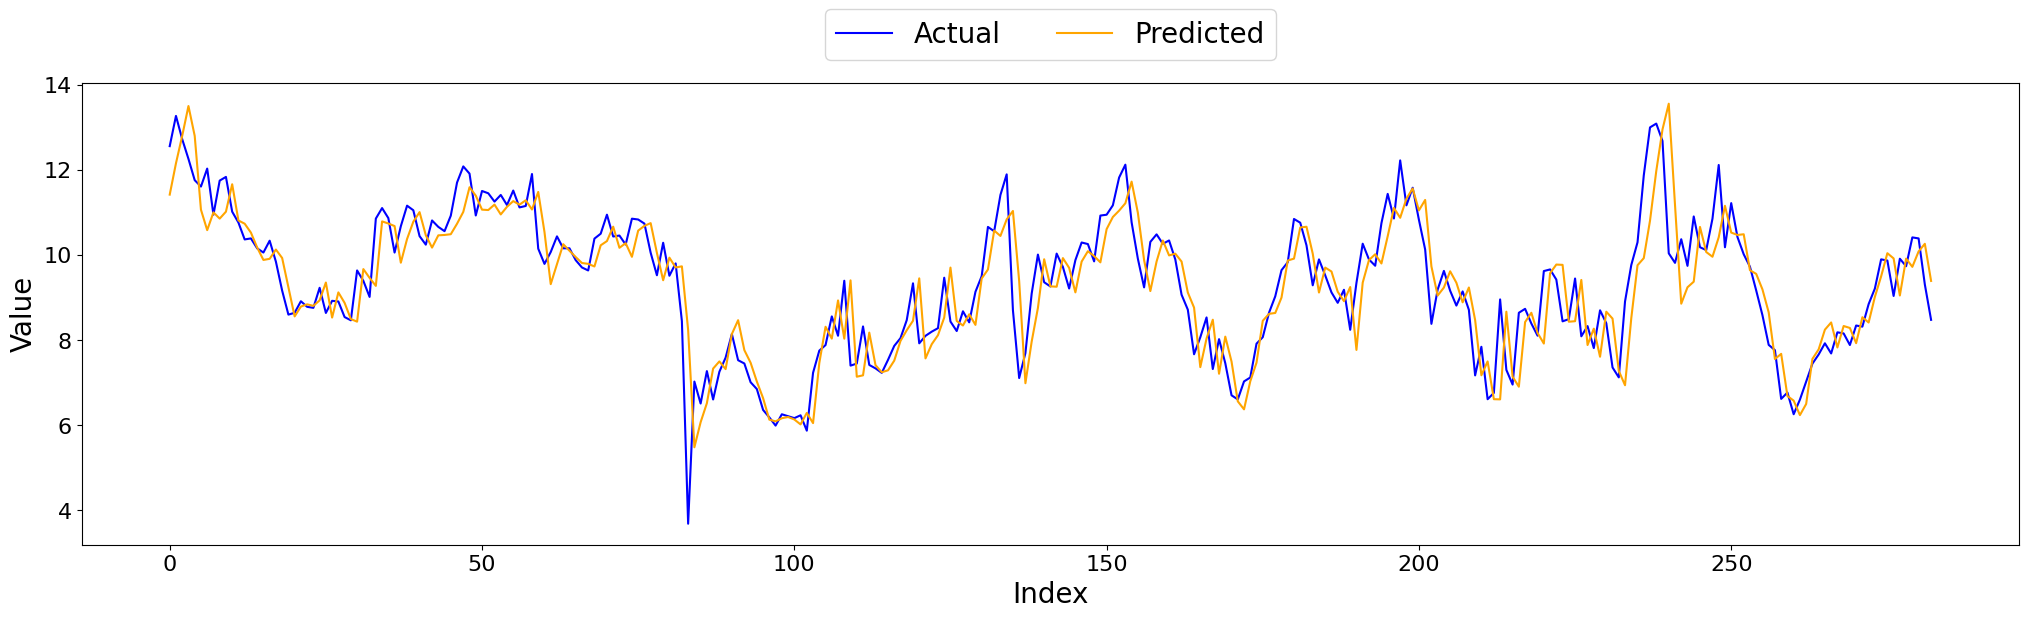

In [23]:
plt.figure(figsize=(25, 6))
plt.plot(y_test, color='blue', label='Actual')
plt.plot(forecasting, color='orange', label='Predicted')

plt.xlabel("Index", size=20)
plt.ylabel("Value", size=20)

# Ajustar el tamaño de los valores de los ejes x e y
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Leyenda en la parte superior, centrada y en 3 columnas
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.02), ncol=3, prop={'size': 20})

plt.show()


In [18]:
R2 = round(r2_score(y_test, np.squeeze(forecasting)), 3)
RMSE = round(mean_squared_error(y_test, np.squeeze(forecasting), squared=False), 3)
MAE = round(mean_absolute_error(y_test, np.squeeze(forecasting)), 3)
MAPE = round(np.mean(np.abs((y_test - np.squeeze(forecasting)) / y_test)) * 100, 3)

# Muestra los resultados
print(f"R2: {R2}")
print(f"RMSE: {RMSE}")
print(f"MAE: {MAE}")
print(f"MAPE: {MAPE}%")

R2: 0.733
RMSE: 0.8330000042915344
MAE: 0.6079999804496765
MAPE: 6.851%
